In [1]:
import numpy as np
from matplotlib import pyplot as plt
from rfp2 import *
from scipy.interpolate import interp2d

In [2]:
ncar = 181
dgrid = 540e-6
w0 = 40e-6

nslice = 1058
h_Plank = 4.135667696e-15
c_speed  = 299792458   
xlamds = 1.261043e-10
isradi = 1
zsep = 140
dt = xlamds*zsep * max(1,isradi) /c_speed

npadt = 1000
npadx = [100, 101]
l_cavity = 3.9*32
l_undulator = 149
w_cavity = 1

In [3]:
fld = read_dfl('../data_long/tap0.03_K1.172_nt28_nf4_n6.out.dfl', ncar =ncar)
#fld = read_dfl('../data_long2/n9_seed.dfl', ncar =ncar)

0.4657783508300781 seconds to read in fld array (34661138,)
read 1058 slices
7.152557373046875e-06 seconds to reshape fld array (1058, 181, 181)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


norm = 48480320955888.92     energy = 2855.0  uJ    t , y  mean = -9.6 fs , -0.1 um      t , y  rms = 8.1 fs , 27.5 um     wt , wy = 16.2 fs , 55.0 um     t , y  fwhm = 18.1 fs , 35.6 um


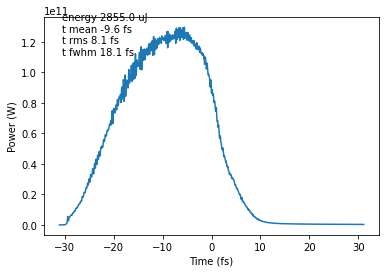

norm = 48480320955888.9     energy = 2855.0  uJ    x , y  mean = -0.2 um , -0.1 um      x , y  rms = 37.7 um , 37.1 um     wx , wy = 75.4 um , 74.2 um     x , y  fwhm = 48.1 um , 48.1 um


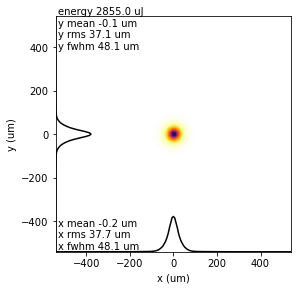

(9831.0, 9833.0)

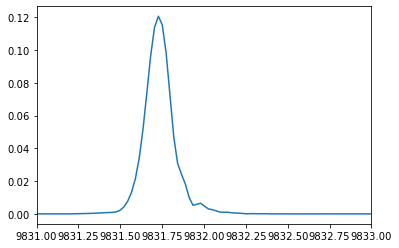

In [4]:
#fld = make_gaus_beam(ncar=ncar, dgrid=dgrid, w0=w0, dt=dt, t0=0., nslice = nslice, trms=20e-15)
plot_fld_power(fld = fld, dt = dt, ax=None, saveFilename=None, showPlotQ=True, savePlotQ=True, logScaleQ=False)
plot_fld_marginalize_t(fld, dgrid = dgrid, dt=dt, saveFilename=None, showPlotQ=True, savePlotQ=True)
hws, spectra = get_spectrum(fld, dt, xlamds, npad = 1000, onaxis=False)
plt.figure()
plt.plot(hws, spectra)
plt.xlim([9831, 9833])

In [5]:

# pad field in time
if int(npadt) > 0:
    fld = pad_dfl_t(fld, [int(npadt),int(npadt)])
    print('Padded field in time by',int(npadt),'slices (',dt*int(npadt)*1e15,'fs) at head and tail')
    print("after padding, fld shape " + str(fld.shape))

# fft
t0 = time.time()
fld = np.fft.fftshift(fft(fld, axis=0), axes=0)
print('took',time.time()-t0,'seconds for fft over t')

Padded field in time by 1000 slices ( 58.88941342213486 fs) at head and tail
after padding, fld shape (3058, 181, 181)
took 4.741211891174316 seconds for fft over t


In [6]:
from Bragg_mirror import *
def Bragg_mirror_reflect(ncar, dgrid, xlamds, nslice, dt, npadx=[0, 0], 
                         verboseQ = True,  d = 50e-6):
    t0 = time.time()
    
    h_Plank = 4.135667696e-15;      # Plank constant [eV-sec]
    c_speed  = 299792458;           # speed of light[m/sec]
    
    # get photon energy coordinate
    hw0_eV = h_Plank * c_speed / xlamds
    Dhw_eV = h_Plank / dt 
    dhw_eV = Dhw_eV / (nslice - 1.)
    eph = hw0_eV + Dhw_eV / 2. * np.linspace(-1.,1.,nslice)
    
    # get transverse angle coordinate
    theta_0 = 45.0*np.pi/180.
    dx = 2. * dgrid / ncar
    Dkx = 2. * np.pi / dx
    Dtheta = Dkx * xlamds / 2. / np.pi
    theta = theta_0 + Dtheta / 2. * np.linspace(-1.,1.,ncar+int(npadx[0]) + int(npadx[1]))
    

   
    R0H = Bragg_mirror_reflection(eph, theta, d).T
    
    R00 = Bragg_mirror_transmission(eph, theta, d).T
        
    if verboseQ: print('took',time.time()-t0,'seconds to calculate Bragg filter')
        
    
    return R0H, R00

nslice_padded = nslice + 2*npadt
R0H, R00 = Bragg_mirror_reflect(ncar = ncar, dgrid = dgrid, xlamds = xlamds, nslice = nslice_padded, dt = dt, npadx=npadx, 
                             verboseQ = True,  d = 100e-6)   #first mirror
R0H_2, R00_2 = Bragg_mirror_reflect(ncar = ncar, dgrid = dgrid, xlamds = xlamds, nslice = nslice_padded, dt = dt, npadx=npadx, 
                             verboseQ = True,  d = 100e-6)   #2-4 mirror




5.7770925916231105e-06
took 1.1126761436462402 seconds to calculate Bragg filter
5.7770925916231105e-06
took 1.0789334774017334 seconds to calculate Bragg filter


In [7]:
R0H.shape

(3058, 382)

In [8]:
nslice_padded = nslice//max(1,isradi) + 2*int(npadt)
nx = ny = ncar
nx_padded = ncar + int(npadx[0]) + int(npadx[1])

# get photon energy coordinate
hw0_eV = h_Plank * c_speed / xlamds
Dhw_eV = h_Plank / dt 
eph = hw0_eV + Dhw_eV / 2. * np.linspace(-1.,1., nslice_padded)
lambd = h_Plank*c_speed/eph

# get kx,ky coordinates
dx = 2. * dgrid / ncar
Dkx = 2. * np.pi / dx
kx = Dkx/ 2. * np.linspace(-1.,1.,nx_padded)
ky = Dkx/ 2. * np.linspace(-1.,1.,ny)
kx_mesh, ky_mesh = np.meshgrid(kx, ky)
kx_mesh = kx_mesh.T
ky_mesh = ky_mesh.T

# get x, y coordinates
xs = (np.arange(nx_padded) - np.floor(nx_padded/2))*dx
ys = (np.arange(ny) - np.floor(ny/2))*dx
xmesh, ymesh = np.meshgrid(xs, ys)
xmesh = xmesh.T
ymesh = ymesh.T

In [9]:
#plt.figure();plt.plot(np.abs(R0H[R0H.shape[0]//2, :]))
#plt.figure();plt.plot(np.abs(R0H[:, R0H.shape[1]//2]))
#plt.figure();plt.plot(np.abs(R00[R00.shape[0]//2, :]))
#plt.figure();plt.plot(np.abs(R00[:, R00.shape[1]//2]))


#plt.figure();plt.plot(np.abs(R0H_2[R0H_2.shape[0]//2, :]))
#plt.figure();plt.plot(np.abs(R0H_2[:, R0H_2.shape[1]//2]))
#plt.figure();plt.plot(np.abs(R00_2[R00_2.shape[0]//2, :]))
#plt.figure();plt.plot(np.abs(R00_2[:, R00_2.shape[1]//2]))

In [10]:
def propagate_slice_kspace(field, z, xlamds, kx, ky):
    H = np.exp(-1j*xlamds*z*(kx**2 + ky**2)/(4*np.pi))
    return field*H
def propagate_slice(fld_slice, npadx,     # fld slice in spectral space, (Ek, x, y)
                             R00_slice, R0H_slice, R00_slice_2, R0H_slice_2,    # Bragg reflection information
                             l_cavity, l_undulator, w_cavity,  # cavity parameter
                             lambd_slice, kx_mesh, ky_mesh, xmesh, ymesh, #fld slice information
                             roundtripQ,               # recirculation parameter
                             misalignQ, M1, M2, M3, M4,        # misalignment parameter
                             roughnessQ, C1, C2, C3, C4,               # roughness parameter
                             verboseQ): 
    
    # propagate one slice around the cavity
    # take a slice in real space, unpadded, return a slice in real space, unpadded
    
    
     # focal length of the lens
    flens1 = (l_cavity + w_cavity)/2
    flens2 = (l_cavity + w_cavity)/2
    
    # propagation length in cavity
    z_und_start = (l_cavity - l_undulator)/2
    z_und_end = z_und_start + l_undulator
    

        
    # pad in x
    if np.sum(npadx) > 0:
        fld_slice = pad_dfl_slice_x(fld_slice, npadx)
   
    # fft to kx, ky space
    t0 = time.time()
    fld_slice = np.fft.fftshift(fft2(fld_slice), axes=(0,1))
    if verboseQ: print('took',time.time()-t0,'seconds for fft over x, y')
    
    # if a roundtrip, propagate from UNDSTART to UNDEND
    if roundtripQ:
        fld_slice = propagate_slice_kspace(field = fld_slice, z = l_undulator, xlamds = lambd_slice, kx = kx_mesh, ky = ky_mesh)
        
    # drift from UNDEND to M1
    Ldrift = l_cavity - z_und_end
        
    fld_slice = propagate_slice_kspace(field = fld_slice, z = Ldrift, xlamds = lambd_slice, kx = kx_mesh, ky = ky_mesh)

    
    # trasmission through M1
    fld_slice_transmit = np.einsum('i,ij->ij',R00_slice,fld_slice)
        
    # reflect from M1
    fld_slice = np.einsum('i,ij->ij',R0H_slice,fld_slice)
    
    # add error of M1 in real space
    if misalignQ or roughnessQ:
        #ifft to the real space
        fld_slice = ifft2(np.fft.ifftshift(fld_slice))
        if misalignQ:
            fld_slice *= np.exp(1j*M1*xmesh)
        if roughnessQ:
            fld_slice *= np.exp(1j*2*2*np.pi/lambd_slice*C1*np.sin(np.pi/4 + M1/2))
        #fft to kx, ky space, check it!!!!
        fld_slice = np.fft.fftshift(fft2(fld_slice))
        
    # drift to the lens
    Ldrift = w_cavity/2
    fld_slice = propagate_slice_kspace(field = fld_slice, z = Ldrift, xlamds = lambd_slice, kx = kx_mesh, ky = ky_mesh)
        
        
    # lens
    f = flens1
    #ifft to the real space
    fld_slice = ifft2(np.fft.ifftshift(fld_slice))
    #apply intracavity focusing CRL
    fld_slice *= np.exp(-1j*np.pi/(f*lambd_slice)*(xmesh**2 + ymesh**2))
    #fft to kx, ky space, check it!!!!
    fld_slice = np.fft.fftshift(fft2(fld_slice))
   
        
        
    # drift to M2
    Ldrift = w_cavity/2
    fld_slice = propagate_slice_kspace(field = fld_slice, z = Ldrift, xlamds = lambd_slice, kx = kx_mesh, ky = ky_mesh)
        
    
    # add error of M2 in real space
    if misalignQ or roughnessQ:
        #ifft to the real space
        fld_slice = ifft2(np.fft.ifftshift(fld_slice))
        if misalignQ:
            fld_slice *= np.exp(1j*M2*xmesh)
        if roughnessQ:
            fld_slice *= np.exp(1j*2*2*np.pi/lambd_slice*C2*np.sin(np.pi/4 + M2/2))
        #fft to kx, ky space, check it!!!!
        fld_slice = np.fft.fftshift(fft2(fld_slice))
    
    
    # reflect from M2
    fld_slice = np.einsum('i,ij->ij',np.flip(R0H_slice_2),fld_slice)
    
    
        
    # drift to M3
    Ldrift = l_cavity
    fld_slice = propagate_slice_kspace(field = fld_slice, z = Ldrift, xlamds = lambd_slice, kx = kx_mesh, ky = ky_mesh)
        
    # reflect from M3
    fld_slice = np.einsum('i,ij->ij',np.flip(R0H_slice_2),fld_slice)
    
    # add error of M3 in real space
    if misalignQ or roughnessQ:
        #ifft to the real space
        fld_slice = ifft2(np.fft.ifftshift(fld_slice))
        if misalignQ:
            fld_slice *= np.exp(1j*M3*xmesh)
        if roughnessQ:
            fld_slice *= np.exp(1j*2*2*np.pi/lambd_slice*C3*np.sin(np.pi/4 + M3/2))
        #fft to kx, ky space, check it!!!!
        fld_slice = np.fft.fftshift(fft2(fld_slice))
        
    # drift to lens
    Ldrift = w_cavity/2
    fld_slice = propagate_slice_kspace(field = fld_slice, z = Ldrift, xlamds = lambd_slice, kx = kx_mesh, ky = ky_mesh)
        
    # lens
    f = flens2
    #ifft to the real space
    fld_slice = ifft2(np.fft.ifftshift(fld_slice))
    #apply intracavity focusing CRL
    fld_slice *= np.exp(-1j*np.pi/(f*lambd_slice)*(xmesh**2 + ymesh**2))
    #fft to kx, ky space, check it!!!!
    fld_slice = np.fft.fftshift(fft2(fld_slice))
  
    # drift to M4
    Ldrift = w_cavity/2
    fld_slice = propagate_slice_kspace(field = fld_slice, z = Ldrift, xlamds = lambd_slice, kx = kx_mesh, ky = ky_mesh)
        
    # reflect from M4
    fld_slice = np.einsum('i,ij->ij',np.flip(R0H_slice_2),fld_slice)
    
    # add error of M4 in real space
    if misalignQ or roughnessQ:
        #ifft to the real space
        fld_slice = ifft2(np.fft.ifftshift(fld_slice))
        if misalignQ:
            fld_slice *= np.exp(1j*M4*xmesh)
        if roughnessQ:
            fld_slice *= np.exp(1j*2*2*np.pi/lambd_slice*C4*np.sin(np.pi/4 + M4/2))
        #fft to kx, ky space, check it!!!!
        fld_slice = np.fft.fftshift(fft2(fld_slice))
    
        
    # drift to undulator start
    Ldrift = z_und_start
    fld_slice = propagate_slice_kspace(field = fld_slice, z = Ldrift, xlamds = lambd_slice, kx = kx_mesh, ky = ky_mesh)
        
    # recirculation finished, ifft to real space
    fld_slice = ifft2(np.fft.ifftshift(fld_slice))
    fld_slice_transmit = ifft2(np.fft.ifftshift(fld_slice_transmit))
   
        
    # unpad in x
    if np.sum(npadx) > 0:
        fld_slice = unpad_dfl_slice_x(fld_slice,  npadx)
        fld_slice_transmit = unpad_dfl_slice_x(fld_slice_transmit,  npadx)

    
    return fld_slice, fld_slice_transmit

In [11]:
root_dir = '/sdf/group/beamphysics/jytang/genesis/CBXFEL/'
misalignQ = True
roughnessQ = False
theta = 400e-9
surface_filename = 'cavity_codes/synthetic_SPring-8'

# prepare error on crystals
if misalignQ:
    M1 = theta*np.random.randn(1)[0] * 2*np.pi/xlamds
    M2 = theta*np.random.randn(1)[0]* 2*np.pi/xlamds
    M3 = theta*np.random.randn(1)[0] * 2*np.pi/xlamds
    M4 = theta*np.random.randn(1)[0] * 2*np.pi/xlamds
else:
    M1 = M2 = M3 = M4 = 0

if roughnessQ:
    nx = ny = ncar
    nx_padded = ncar + int(npadx[0]) + int(npadx[1])
    dx = 2. * dgrid / ncar
    # get x, y coordinates
    xs = (np.arange(nx_padded) - np.floor(nx_padded/2))*dx
    ys = (np.arange(ny) - np.floor(ny/2))*dx
    
    
    fname = root_dir + surface_filename + '_001.txt'
    C1h = np.loadtxt(fname)
    C1h *= 1e-10
    xa = np.linspace(-500e-6, 500e-6, C1h.shape[1])
    ya = np.linspace(-500e-6, 500e-6, C1h.shape[0])
    
    f = interp2d(xa, ya, C1h, kind='cubic')
    C1 = f(xs, ys)
    C1 = C1.T
    
    fname = root_dir + surface_filename + '_002.txt'
    C2h = np.loadtxt(fname)
    C2h *= 1e-10
    f = interp2d(xa, ya, C2h, kind='cubic')
    C2 = f(xs, ys)
    C2 = C2.T
    
    fname = root_dir + surface_filename + '_003.txt'
    C3h = np.loadtxt(fname)
    C3h *= 1e-10
    f = interp2d(xa, ya, C3h, kind='cubic')
    C3 = f(xs, ys)
    C3 = C3.T
    
    fname = root_dir + surface_filename + '_004.txt'
    C4h = np.loadtxt(fname)
    C4h *= 1e-10
    f = interp2d(xa, ya, C4h, kind='cubic')
    C4 = f(xs, ys)
    C4 = C4.T

else:
    C1 = C2 = C3 = C4 = None

In [12]:
#xmesh, ymesh = np.meshgrid(xs, ys)
#xmesh = xmesh.T
#ymesh = ymesh.T
#fig = plt.figure()
#ax = fig.gca(projection ='3d')
#ax.plot_surface(xmesh, ymesh, C1)

#fig = plt.figure()
#ax = fig.gca(projection ='3d')
#ax.plot_surface(xmesh, ymesh, C2)

#fig = plt.figure()
#ax = fig.gca(projection ='3d')
#ax.plot_surface(xmesh, ymesh, C3)

#fig = plt.figure()
#ax = fig.gca(projection ='3d')
#ax.plot_surface(xmesh, ymesh, C4)

#[Xa, Ya] = np.meshgrid(xa, ya)
#fig = plt.figure()
#ax = fig.gca(projection ='3d')
#ax.plot_surface(Xa, Ya, C1h)


In [13]:
fld_transmit = np.zeros(fld.shape, dtype=np.complex_)
for k in range(fld.shape[0]):
    if k%100 == 0:
        print('finish ' + str(np.round(k/fld.shape[0],2)*100) + '%')
    fld_slice = np.squeeze(fld[k, :, :])
    R00_slice = np.squeeze(R00[k, :])
    R0H_slice = np.squeeze(R0H[k, :])
    R00_slice_2 = np.squeeze(R00_2[k, :])
    R0H_slice_2 = np.squeeze(R0H_2[k, :])
    lambd_slice = lambd[k]
    
    fld_slice, fld_slice_transmit = propagate_slice(fld_slice = fld_slice, npadx = npadx,     
                             R00_slice = R00_slice, R0H_slice = R0H_slice,  R00_slice_2 = R00_slice_2, R0H_slice_2 = R0H_slice_2,    
                             l_cavity = l_cavity, l_undulator = l_undulator, w_cavity = w_cavity,  
                             lambd_slice = lambd_slice, kx_mesh = kx_mesh, ky_mesh = ky_mesh, xmesh = xmesh, ymesh = ymesh, 
                             roundtripQ = False,
                             misalignQ = misalignQ, M1 = M1, M2 =M2, M3=M3,  M4= M4,        # misalignment parameter
                             roughnessQ =roughnessQ, C1= C1, C2 = C2, C3 = C3, C4 = C4,               # roughness parameter
                             verboseQ = False)
    fld[k,:, :] = fld_slice
    fld_transmit[k, :, :] = fld_slice_transmit

# ifft to time domain
#----------------------
t0 = time.time()
fld = ifft(np.fft.ifftshift(fld,axes = 0), axis=0)
print('took',time.time()-t0,'seconds for ifft over t')
 

finish 0.0%
finish 3.0%
finish 7.000000000000001%
finish 10.0%
finish 13.0%
finish 16.0%
finish 20.0%
finish 23.0%
finish 26.0%
finish 28.999999999999996%
finish 33.0%
finish 36.0%
finish 39.0%
finish 43.0%
finish 46.0%
finish 49.0%
finish 52.0%
finish 56.00000000000001%
finish 59.0%
finish 62.0%
finish 65.0%
finish 69.0%
finish 72.0%
finish 75.0%
finish 78.0%
finish 82.0%
finish 85.0%
finish 88.0%
finish 92.0%
finish 95.0%
finish 98.0%
took 4.247588634490967 seconds for ifft over t


In [14]:
fld.shape

(3058, 181, 181)

norm = 1835546518387.211     energy = 108.1  uJ    t , y  mean = -19.7 fs , -0.1 um      t , y  rms = 29.3 fs , 70.2 um     wt , wy = 58.6 fs , 140.4 um     t , y  fwhm = 56.4 fs , 169.0 um


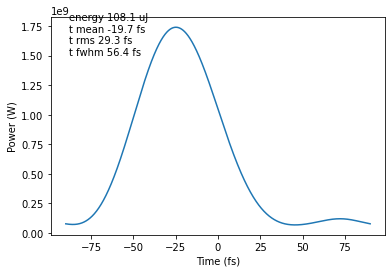

norm = 1835546518387.2114     energy = 108.1  uJ    x , y  mean = 87.6 um , -0.1 um      x , y  rms = 100.0 um , 94.7 um     wx , wy = 200.0 um , 189.4 um     x , y  fwhm = 194.1 um , 228.2 um


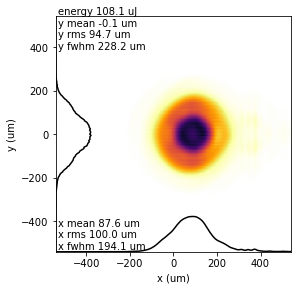

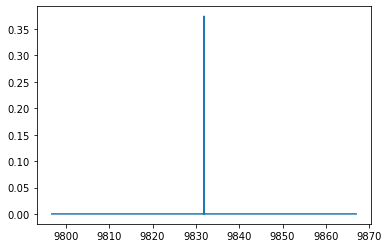

In [15]:
plot_fld_power(fld = fld, dt = dt, ax=None, saveFilename=None, showPlotQ=True, savePlotQ=True, logScaleQ=False)
plot_fld_marginalize_t(fld, dgrid = dgrid, dt=dt, saveFilename=None, showPlotQ=True, savePlotQ=True)
hws, spectra = get_spectrum(fld, dt, xlamds, npad = 1000, onaxis=False)
plt.figure()
plt.plot(hws, spectra)
#plt.xlim([9831, 9833])